In [1]:
import os
import numpy as np
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing import sequence
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [3]:
os.chdir('NLP/Data')

In [4]:
imdb_data = pd.read_csv('IMDB_Dataset.csv')

In [5]:
le = LabelEncoder()
imdb_data['target'] = le.fit_transform(imdb_data.sentiment)
imdb_data.drop('sentiment', axis=1, inplace=True)

In [6]:
lemmatizer = WordNetLemmatizer()
en_stop = set(stopwords.words('english'))
              
def cleaning_text(document):
        
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # remove numbers
        #document = re.sub(r'\d+', '', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        #tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [7]:
print('Time Start : ',datetime.now())
imdb_data['review'] = imdb_data['review'].apply(cleaning_text)
print('Time End : ',datetime.now())

Time Start :  2020-09-25 11:16:46.421002
Time End :  2020-09-25 11:17:54.842694


In [8]:
imdb_data['review'].head(5)

0    one reviewer ha mentioned watching 1 oz episod...
1    wonderful little production br br filming tech...
2    thought wa wonderful way spend time hot summer...
3    basically family little boy jake think zombie ...
4    petter mattei love time money visually stunnin...
Name: review, dtype: object

In [9]:
vectorizer_X = TfidfVectorizer(analyzer='word', max_df=0.5, min_df=2,
                                   strip_accents = None, encoding = 'utf-8',
                                   preprocessor=None)

# TF-IDF matrices
imdb_vect = vectorizer_X.fit_transform(imdb_data['review'].values)

In [10]:
imdb_vect.shape

(50000, 52904)

In [11]:
vectorizer = TfidfVectorizer(min_df=13)
imdb_vect = vectorizer.fit_transform(imdb_data['review'].values)

In [12]:
imdb_vect.shape

(50000, 20258)

In [13]:
X = imdb_vect.toarray()
y = (np.array(imdb_data['target']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [14]:
print("X Train dataset shape: ", X_train.shape)
print("X Test dataset shape: ", X_test.shape)
print("Y Train dataset shape: ", y_train.shape)
print("Y Test dataset shape: ", y_test.shape)

X Train dataset shape:  (40000, 20258)
X Test dataset shape:  (10000, 20258)
Y Train dataset shape:  (40000,)
Y Test dataset shape:  (10000,)


In [15]:
MAX_LEN = 200
RNN_CELL_SIZE = 128
VOCAB_SIZE = 10000
EMBED_SIZE = 128

pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

In [16]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN, truncating='post', padding='post', value=pad_id)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN, truncating='post', padding='post', value=pad_id)

# Attention Layer

In [17]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

# Embed Layer

In [18]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_LEN)(sequence_input)

# Bi-directional LSTM

In [19]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, 
                          dropout=0.3,
                          return_sequences = True, 
                          return_state=True,
                          recurrent_activation='relu',
                          recurrent_initializer='glorot_uniform'), name="bi_lstm_0")(embedded_sequences)


# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE,
                                                                          dropout=0.2,
                                                                          return_sequences=True, 
                                                                          return_state=True,
                                                                          recurrent_activation='relu',
                                                                          recurrent_initializer='glorot_uniform'), 
                                                                          name="bi_lstm_1")(lstm)

In [20]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

dense_ = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense_)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 128)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       [(None, 200, 256), ( 263168      embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 200, 256), ( 394240      bi_lstm_0[0][0]                  
                                                                 bi_lstm_0[0][1]              

# Plot Model

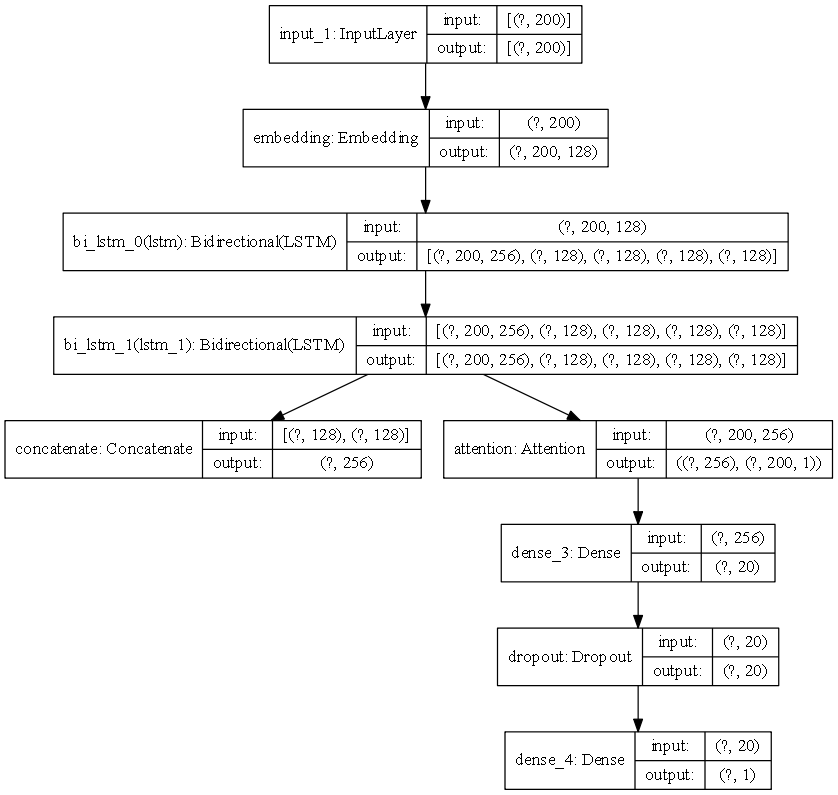

In [21]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

# Compile Model

In [22]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'), 
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

# Train Model

In [23]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, 
                                                        mode='auto')

BATCH_SIZE = 200
EPOCHS = 10

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.3, 
                    verbose=1, callbacks=[early_stopping_callback])

Train on 28000 samples, validate on 12000 samples
Epoch 1/10
28000/28000 [==============================] - 6132s 219ms/sample - loss: 0.6932 - tp: 9229.0000 - fp: 9064.0000 - tn: 4857.0000 - fn: 4850.0000 - accuracy: 0.5031 - precision: 0.5045 - recall: 0.6555 - auc: 0.5007 - val_loss: 0.6932 - val_tp: 5992.0000 - val_fp: 6008.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4993 - val_precision: 0.4993 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/10
28000/28000 [==============================] - 10525s 376ms/sample - loss: 0.6932 - tp: 14079.0000 - fp: 13921.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5028 - precision: 0.5028 - recall: 1.0000 - auc: 0.4980 - val_loss: 0.6932 - val_tp: 5992.0000 - val_fp: 6008.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4993 - val_precision: 0.4993 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/10
28000/28000 [==============================] - 8478s 303ms/sample - loss: 0.6932 - tp: 12019.0000 - fp: 1189

# Evaluating the Model

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6932357566833496
Test accuracy: 4929.0


In [33]:
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

In [36]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5071
           1       0.49      1.00      0.66      4929

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.33     10000



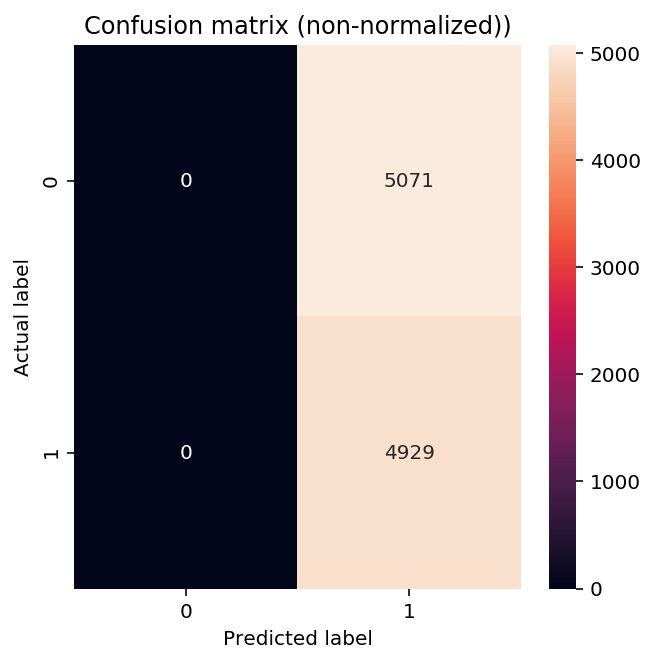

In [37]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

plot_cm(y_test, y_pred)